In [32]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from matplotlib import pyplot as plt

In [33]:
distance_to_obstacle = ctrl.Antecedent(np.arange(0, 101, 1), 'distance_to_obstacle')
distance_to_target = ctrl.Antecedent(np.arange(0, 101, 1), 'distance_to_target')
angle_error = ctrl.Antecedent(np.arange(-180, 181, 1), 'angle_error')


speed_change = ctrl.Consequent(np.arange(-100, 101, 1), 'speed_change')
heading_change = ctrl.Consequent(np.arange(-45, 46, 1), 'heading_change')

In [34]:
distance_to_obstacle['far'] = fuzz.trimf(distance_to_obstacle.universe, [50, 100, 100])
distance_to_obstacle['very_far'] = fuzz.trimf(distance_to_obstacle.universe, [80, 100, 100])

distance_to_target['on_top'] = fuzz.trimf(distance_to_target.universe, [0, 0, 20])
distance_to_target['medium'] = fuzz.trimf(distance_to_target.universe, [20, 50, 80])
distance_to_target['far'] = fuzz.trimf(distance_to_target.universe, [50, 100, 100])

angle_error['neg_big'] = fuzz.trimf(angle_error.universe, [-180, -180, -90])
angle_error['neg_med'] = fuzz.trimf(angle_error.universe, [-90, -45, 0])
angle_error['neg_small'] = fuzz.trimf(angle_error.universe, [-30, -10, 0])
angle_error['zero'] = fuzz.trimf(angle_error.universe, [-1, 0, 1])
angle_error['pos_small'] = fuzz.trimf(angle_error.universe, [0, 10, 30])
angle_error['pos_med'] = fuzz.trimf(angle_error.universe, [30, 90, 120])
angle_error['pos_big'] = fuzz.trimf(angle_error.universe, [90, 180, 180])

speed_change['very_slow'] = fuzz.trimf(speed_change.universe, [-100, -100, -50])
speed_change['slow'] = fuzz.trimf(speed_change.universe, [-50, 0, 50])
speed_change['fast'] = fuzz.trimf(speed_change.universe, [50, 100, 100])
speed_change['very_fast'] = fuzz.trimf(speed_change.universe, [75, 100, 100])

heading_change['neg_big'] = fuzz.trimf(heading_change.universe, [-45, -45, -15])
heading_change['neg_med'] = fuzz.trimf(heading_change.universe, [-15, -10, 0])
heading_change['neg_small'] = fuzz.trimf(heading_change.universe, [-5, 0, 0])
heading_change['zero'] = fuzz.trimf(heading_change.universe, [-1, 0, 1])
heading_change['pos_small'] = fuzz.trimf(heading_change.universe, [0, 5, 15])
heading_change['pos_med'] = fuzz.trimf(heading_change.universe, [10, 15, 45])
heading_change['pos_big'] = fuzz.trimf(heading_change.universe, [15, 45, 45])


In [35]:
rule1 = ctrl.Rule(distance_to_obstacle['very_far'] & distance_to_target['far'], 
                  (speed_change['fast'], heading_change['zero']))
rule2 = ctrl.Rule(distance_to_obstacle['very_far'] & distance_to_target['medium'], 
                  (speed_change['slow'], heading_change['zero']))
rule3 = ctrl.Rule(distance_to_obstacle['very_far'] & distance_to_target['on_top'], 
                  (speed_change['very_slow'], heading_change['zero']))

rule4 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['neg_big'], 
                  (speed_change['fast'], heading_change['neg_big']))
rule5 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['neg_med'], 
                  (speed_change['slow'], heading_change['neg_med']))
rule6 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['neg_small'], 
                  (speed_change['slow'], heading_change['neg_small']))

rule7 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['zero'], 
                  (speed_change['fast'], heading_change['zero']))
rule8 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['pos_small'], 
                  (speed_change['slow'], heading_change['pos_small']))
rule9 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['pos_med'], 
                  (speed_change['slow'], heading_change['pos_med']))
rule10 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['pos_big'], 
                   (speed_change['fast'], heading_change['pos_big']))


In [36]:
uav_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10])
uav_simulation = ctrl.ControlSystemSimulation(uav_ctrl)

current_distance_to_target = np.random.uniform(20, 100) 
current_angle_error = np.random.uniform(-180, 180)      
current_speed = np.random.uniform(20, 80)                


In [37]:
speed_changes = []
heading_changes = []
distances_to_target = []
angle_errors = []
speeds = []

for step in range(50):  
    uav_simulation.input['distance_to_obstacle'] = 90  
    uav_simulation.input['distance_to_target'] = current_distance_to_target
    uav_simulation.input['angle_error'] = current_angle_error

    uav_simulation.compute()

    speed_change = uav_simulation.output['speed_change']
    heading_change = uav_simulation.output['heading_change']

    current_speed += speed_change / 10
    current_angle_error -= heading_change  

    current_distance_to_target -= current_speed * 0.1
    current_distance_to_target = max(current_distance_to_target, 0)  

    speed_changes.append(speed_change)
    heading_changes.append(heading_change)
    distances_to_target.append(current_distance_to_target)
    angle_errors.append(current_angle_error)
    speeds.append(current_speed)

    print(f"Korak {step + 1}:")
    print(f"  Promena brzine: {speed_change:.2f}")
    print(f"  Promena ugla pravca: {heading_change:.2f}")
    print(f"  Trenutna brzina: {current_speed:.2f}")
    print(f"  Trenutna udaljenost do cilja: {current_distance_to_target:.2f}")
    print(f"  Trenutna greška u uglu: {current_angle_error:.2f}\n")

    if current_distance_to_target <= 0:
        print("Letelica je stigla do cilja.")
        break

Korak 1:
  Promena brzine: 32.63
  Promena ugla pravca: -6.71
  Trenutna brzina: 47.17
  Trenutna udaljenost do cilja: 79.93
  Trenutna greška u uglu: -68.45

Korak 2:
  Promena brzine: 27.38
  Promena ugla pravca: -7.09
  Trenutna brzina: 49.91
  Trenutna udaljenost do cilja: 74.94
  Trenutna greška u uglu: -61.36

Korak 3:
  Promena brzine: 26.82
  Promena ugla pravca: -7.14
  Trenutna brzina: 52.59
  Trenutna udaljenost do cilja: 69.68
  Trenutna greška u uglu: -54.22

Korak 4:
  Promena brzine: 23.58
  Promena ugla pravca: -7.27
  Trenutna brzina: 54.95
  Trenutna udaljenost do cilja: 64.19
  Trenutna greška u uglu: -46.95

Korak 5:
  Promena brzine: 19.20
  Promena ugla pravca: -7.13
  Trenutna brzina: 56.87
  Trenutna udaljenost do cilja: 58.50
  Trenutna greška u uglu: -39.81

Korak 6:
  Promena brzine: 13.24
  Promena ugla pravca: -7.13
  Trenutna brzina: 58.19
  Trenutna udaljenost do cilja: 52.68
  Trenutna greška u uglu: -32.68

Korak 7:
  Promena brzine: 4.93
  Promena ugla

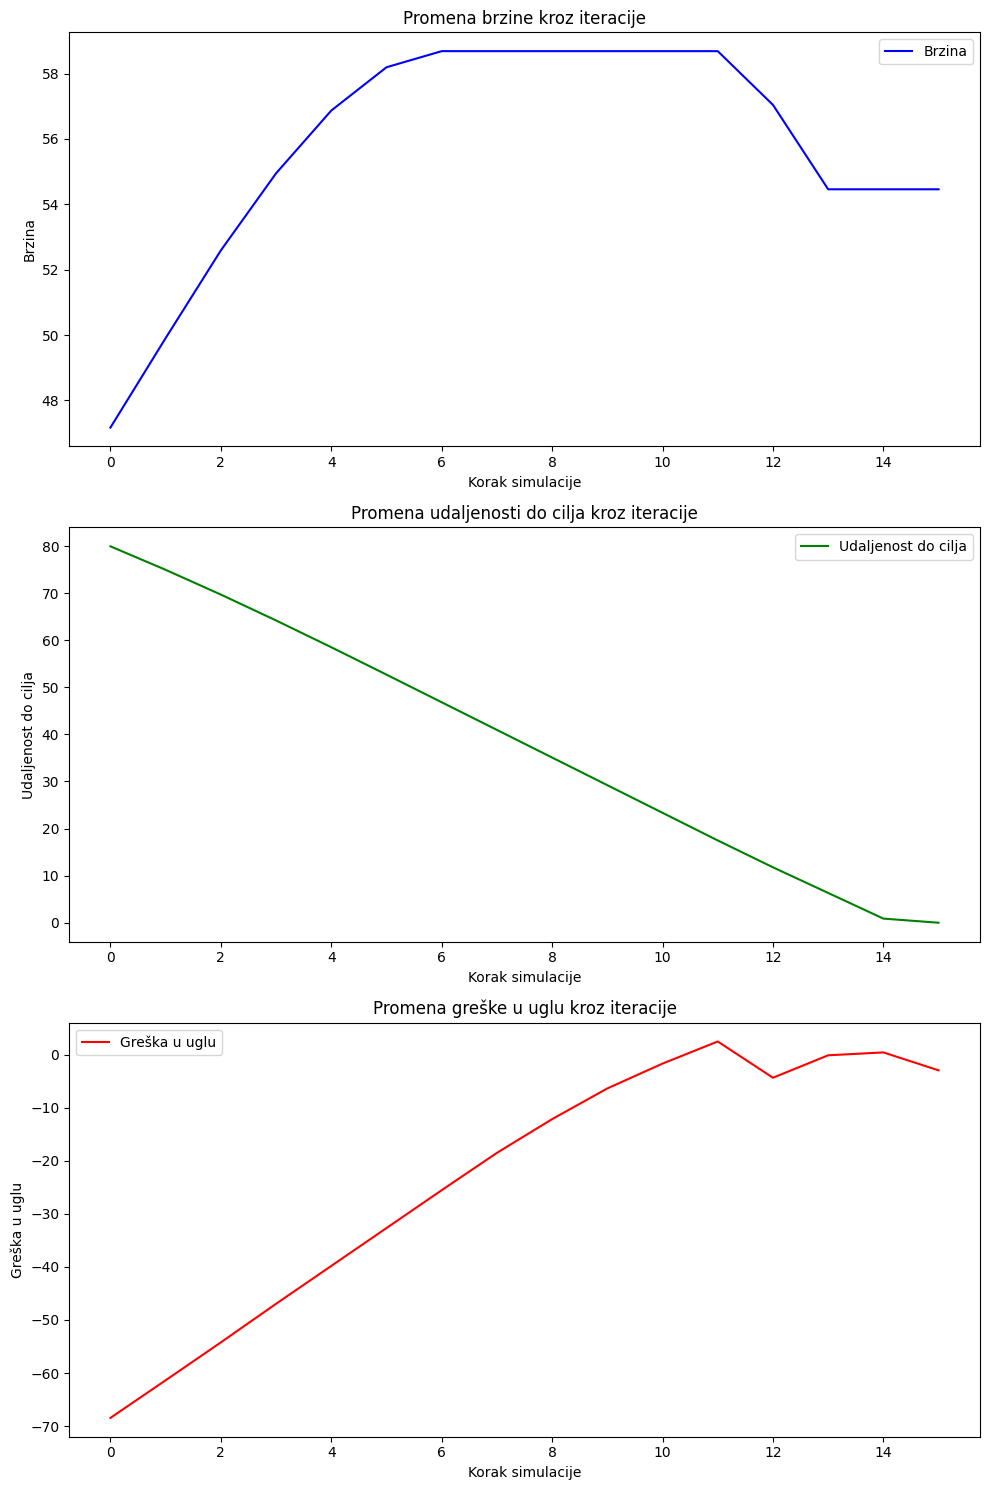

In [38]:
fig, axs = plt.subplots(3, figsize=(10, 15))

axs[0].plot(speeds, label='Brzina', color='blue')
axs[0].set_title('Promena brzine kroz iteracije')
axs[0].set_xlabel('Korak simulacije')
axs[0].set_ylabel('Brzina')
axs[0].legend()

axs[1].plot(distances_to_target, label='Udaljenost do cilja', color='green')
axs[1].set_title('Promena udaljenosti do cilja kroz iteracije')
axs[1].set_xlabel('Korak simulacije')
axs[1].set_ylabel('Udaljenost do cilja')
axs[1].legend()

axs[2].plot(angle_errors, label='Greška u uglu', color='red')
axs[2].set_title('Promena greške u uglu kroz iteracije')
axs[2].set_xlabel('Korak simulacije')
axs[2].set_ylabel('Greška u uglu')
axs[2].legend()

plt.tight_layout()
plt.show()

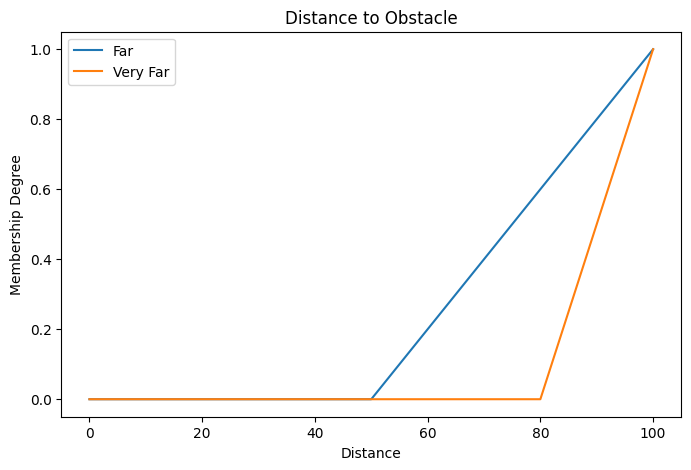

In [39]:
plt.figure(figsize=(8, 5))

plt.plot(distance_to_obstacle.universe, fuzz.trimf(distance_to_obstacle.universe, [50, 100, 100]), label='Far')
plt.plot(distance_to_obstacle.universe, fuzz.trimf(distance_to_obstacle.universe, [80, 100, 100]), label='Very Far')

plt.title('Distance to Obstacle')
plt.xlabel('Distance')
plt.ylabel('Membership Degree')
plt.legend()
plt.show()

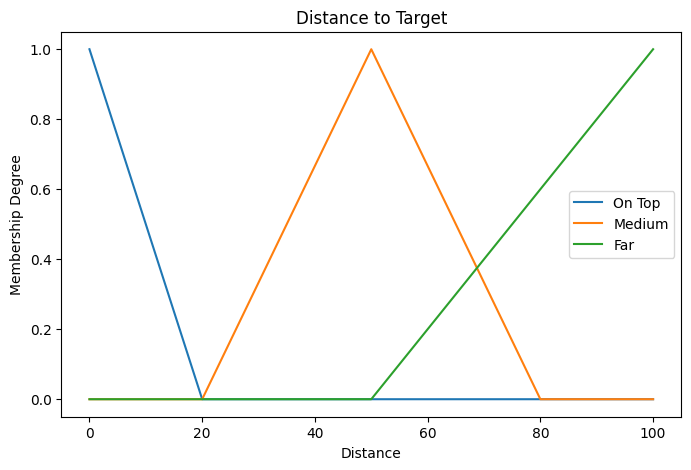

In [40]:
plt.figure(figsize=(8, 5))

plt.plot(distance_to_target.universe, fuzz.trimf(distance_to_target.universe, [0, 0, 20]), label='On Top')
plt.plot(distance_to_target.universe, fuzz.trimf(distance_to_target.universe, [20, 50, 80]), label='Medium')
plt.plot(distance_to_target.universe, fuzz.trimf(distance_to_target.universe, [50, 100, 100]), label='Far')

plt.title('Distance to Target')
plt.xlabel('Distance')
plt.ylabel('Membership Degree')
plt.legend()
plt.show()


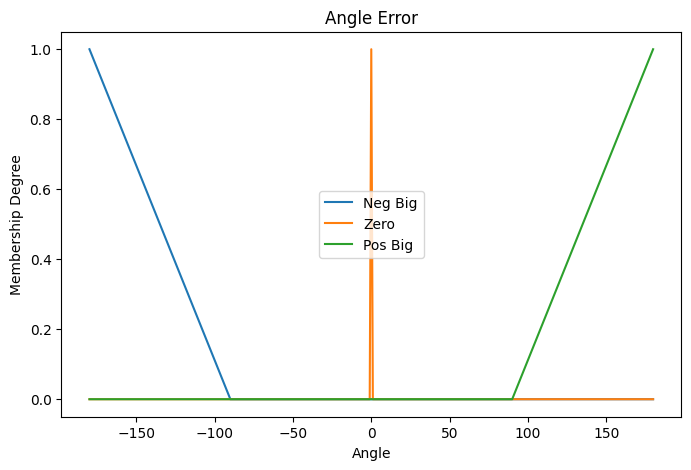

In [41]:
plt.figure(figsize=(8, 5))

plt.plot(angle_error.universe, fuzz.trimf(angle_error.universe, [-180, -180, -90]), label='Neg Big')
plt.plot(angle_error.universe, fuzz.trimf(angle_error.universe, [-1, 0, 1]), label='Zero')
plt.plot(angle_error.universe, fuzz.trimf(angle_error.universe, [90, 180, 180]), label='Pos Big')

plt.title('Angle Error')
plt.xlabel('Angle')
plt.ylabel('Membership Degree')
plt.legend()
plt.show()

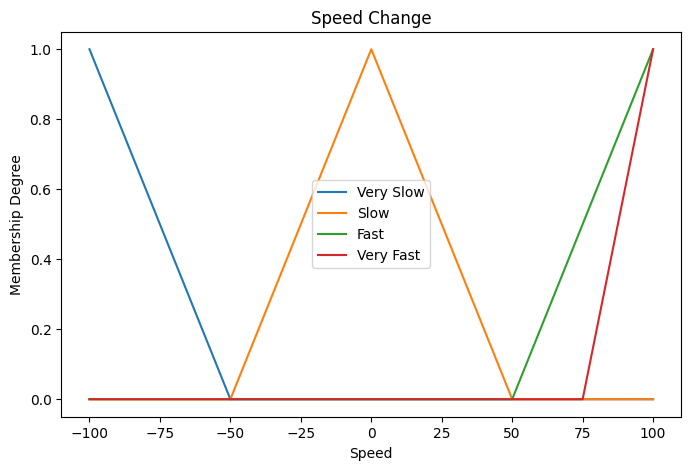

In [42]:
speed_universe = np.arange(-100, 101, 1)

plt.figure(figsize=(8, 5))

# Definisanje i crtanje funkcija pripadnosti
plt.plot(speed_universe, fuzz.trimf(speed_universe, [-100, -100, -50]), label='Very Slow')
plt.plot(speed_universe, fuzz.trimf(speed_universe, [-50, 0, 50]), label='Slow')
plt.plot(speed_universe, fuzz.trimf(speed_universe, [50, 100, 100]), label='Fast')
plt.plot(speed_universe, fuzz.trimf(speed_universe, [75, 100, 100]), label='Very Fast')

# Postavke grafika
plt.title('Speed Change')
plt.xlabel('Speed')
plt.ylabel('Membership Degree')
plt.legend()
plt.show()